In [2]:
import numpy as np
import gzip
import struct
import matplotlib.pyplot as plt
import sys


#########################
##   MNIST Data Load   ##
#########################

def read_data(label_path, image_path):
    with gzip.open(label_path) as flbl:
        _, _ = struct.unpack(">II", flbl.read(8))
        label = np.fromstring(flbl.read(), dtype=np.int8)
    with gzip.open(image_path, 'rb') as fimg:
        _, _, rows, cols = struct.unpack(">IIII", fimg.read(16))
        image = np.fromstring(fimg.read(), dtype=np.uint8).reshape(len(label), rows, cols)
    return (label, image)

path = "data/"
(train_label, train_img) = read_data(path+'train-labels-idx1-ubyte.gz', path+'train-images-idx3-ubyte.gz')
(val_label, val_img) = read_data(path+'t10k-labels-idx1-ubyte.gz', path+'t10k-images-idx3-ubyte.gz')


#########################
##   Parameter Init    ##
#########################

def init_params(input_dims, output_dims):
    np.random.seed(1)

    W = np.random.randn(output_dims, input_dims) * 0.1
    b = np.zeros(shape=(output_dims, 1))

    assert (W.shape == (output_dims, input_dims))
    assert (b.shape == (output_dims, 1))

    parameters = {"W": W,
                  "b": b,
                  }

    return parameters


#########################
##  Forward Operation  ##
#########################

def linear_forward(A, W, b):
    Z = np.dot(W, A) + b
    assert (Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)

    return Z, cache

def linear_activation_forward(A_prev, W, b, activation):

    Z, linear_cache = linear_forward(A_prev, W, b)
    if activation == "sigmoid":
        A, activation_cache = sigmoid(Z)

    elif activation == "relu":
        A, activation_cache = relu(Z)
    
    elif activation == "softmax":
        A, activation_cache = softmax(Z)

    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache


#########################
## Activation Function ##
#########################

def derivative_sigmoid(Z):
    return (1/(1+np.exp(-Z)) * (1-1/(1+np.exp(-Z))))

def derivative_relu(Z):
    return 1. * (Z > 0)

def sigmoid(Z):
    # Prevent numpy.exp Overflow Error
    Z = Z.astype("float128")
    return 1/(1+np.exp(-Z)), derivative_sigmoid(Z)

def relu(Z):
    return np.maximum(0, Z), derivative_relu(Z)


#########################
##    Calculate Loss   ##
#########################

def compute_cost(AL, Y):
    m = Y.shape[0]

    # MSE Error
    cost = (1 / m) * np.sum(np.square(Y-AL))
    cost = np.squeeze(cost)
    assert (cost.shape == ())

    return cost, derivative_cost(AL, Y)

#########################
##  Back Propagation   ##
#########################

def softmax_backward(dA, activation_cache):
    return np.multiply(dA, activation_cache)

def relu_backward(dA, activation_cache):
    return np.multiply(dA, activation_cache)

def sigmoid_backward(dA, activation_cache):
    return np.multiply(dA, activation_cache)

def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = np.dot(dZ, A_prev.T) / m
    db = np.reshape(np.squeeze(np.sum(dZ, axis=1, keepdims=True)) / m, b.shape)
    dA_prev = np.dot(W.T, dZ)

    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)

    return dA_prev, dW, db


def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache

    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
    elif activation == "softmax":
        dZ = softmax_backward(dA, activation_cache)

    dA_prev, dW, db = linear_backward(dZ, linear_cache)

    return dA_prev, dW, db


def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2

    for l in range(1, L):
        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - learning_rate * grads["dW" + str(l + 1)]
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * grads["db" + str(l + 1)]

    return parameters

#########################
##      Test Cost      ##
#########################

# Number of Train Data
num_train_data = len(train_img)
# Get array for Shuffle
arr = np.arange(num_train_data)

# Class number
classes = 10

# Define Hyper parameters
epoch = 1
learning_rate = 0.1
batch_size = 128

# Init Params
layer1_parameters = init_params(784,1000)
layer2_parameters = init_params(1000,100)
layer3_parameters = init_params(100,classes)

parameters = {
    "W1"    :   layer1_parameters["W"],
    "b1"    :   layer1_parameters["b"],
    "W2"    :   layer2_parameters["W"],
    "b2"    :   layer2_parameters["b"],
    "W3"    :   layer3_parameters["W"],
    "b3"    :   layer3_parameters["b"]
}

grads = {}
Error = []

for j in range(epoch):

    # Shuffle Data
    np.random.shuffle(arr)

    for i in range(num_train_data):

        # Define Input Data Pair
        data_index = arr[i]
        X, Y = train_img[data_index].reshape(784, 1), train_label[data_index]
        label = np.array([int(i==int(Y)) for i in range(classes)]).reshape(classes,1)

        # Forward Operation
        A1, layer1_cache = linear_activation_forward(X, parameters["W1"], parameters["b1"], "sigmoid")
        A2, layer2_cache = linear_activation_forward(A1, parameters["W2"], parameters["b2"], "sigmoid")
        A3, layer3_cache = linear_activation_forward(A2, parameters["W3"], parameters["b3"], "sigmoid")

        # MSE Error
        cost,_  = compute_cost(label, A3)
        
        # derivative MSE Error
        m = label.shape[0]
        dCost = (-2/m)*(label-A3)
        
        # Display Error
        if (i % 5000 == 0):
            print("Iteration : {}, \t Error : {}, learning_rate : {}, \t index : {}, \t label : {}".format((j * num_train_data) + i, cost, learning_rate,Y, label.reshape(1, 10)))
            Error.append(cost)
        
        #if (i > 0) and (i % 25000) == 0:
        #    learning_rate /= 10

        # Backpropagation
        grads["dA3"], grads["dW3"], grads["db3"] = linear_activation_backward(dCost, layer3_cache, 'sigmoid')
        grads["dA2"], grads["dW2"], grads["db2"] = linear_activation_backward(grads["dA3"], layer2_cache, 'sigmoid')
        grads["dA1"], grads["dW1"], grads["db1"] = linear_activation_backward(grads["dA2"], layer1_cache, 'sigmoid')

        # Update Parameters
        parameters = update_parameters(parameters, grads, learning_rate)


Iteration : 0, 	 Error : 0.2921405088296691, learning_rate : 0.1, 	 index : 8, 	 label : [[0 0 0 0 0 0 0 0 1 0]]
Iteration : 5000, 	 Error : 0.026915249991228036, learning_rate : 0.1, 	 index : 7, 	 label : [[0 0 0 0 0 0 0 1 0 0]]
Iteration : 10000, 	 Error : 0.0056756708980813565, learning_rate : 0.1, 	 index : 0, 	 label : [[1 0 0 0 0 0 0 0 0 0]]
Iteration : 15000, 	 Error : 0.006258436135574752, learning_rate : 0.1, 	 index : 3, 	 label : [[0 0 0 1 0 0 0 0 0 0]]
Iteration : 20000, 	 Error : 0.00235090551208013, learning_rate : 0.1, 	 index : 4, 	 label : [[0 0 0 0 1 0 0 0 0 0]]
Iteration : 25000, 	 Error : 0.0005777293422667369, learning_rate : 0.1, 	 index : 1, 	 label : [[0 1 0 0 0 0 0 0 0 0]]
Iteration : 30000, 	 Error : 0.002861196324094797, learning_rate : 0.1, 	 index : 2, 	 label : [[0 0 1 0 0 0 0 0 0 0]]
Iteration : 35000, 	 Error : 0.0024932036261167034, learning_rate : 0.1, 	 index : 7, 	 label : [[0 0 0 0 0 0 0 1 0 0]]
Iteration : 40000, 	 Error : 0.004742057281351694, le

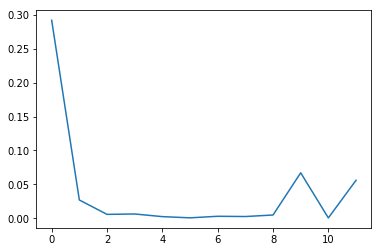

In [4]:
x = np.arange(len(Error))
plt.plot(x, Error)
plt.show()

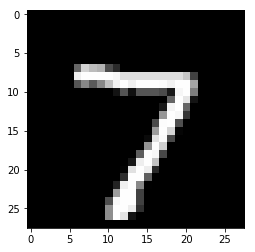

Predict value : 7, OutPut scalar : 

[[ 0.0029043064  0.0015470979  0.0036411382  0.054652748  0.0009454799
   0.0027472847  5.7627459e-05  0.99294222  0.0009277754  0.009615511]]


In [5]:
classes = 10
label = np.array([int(i==int(val_label[0])) for i in range(classes)]).reshape(classes,1)
Input = val_img[0]
plt.imshow(Input, cmap='Greys_r')
plt.show()

Input = Input.reshape(784,1)


A1, caches1 = linear_activation_forward(Input, parameters["W1"], parameters["b1"], "sigmoid")
A2, caches2 = linear_activation_forward(A1, parameters["W2"], parameters["b2"], "sigmoid")
A3, caches3 = linear_activation_forward(A2, parameters["W3"], parameters["b3"], "sigmoid")

val = np.argmax(A3)
print("Predict value : {}, OutPut scalar : \n\n{}".format(val, A3.reshape(1,10)))